In [86]:
import cv2
import PIL
import random
import numpy as np
import os
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pdb

from skimage.morphology import label

from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.nn.functional import binary_cross_entropy_with_logits
import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, Sampler

from fastai.vision.data import SegmentationItemList, SegmentationLabelList, ImageList
from fastai.data_block import FloatList, FloatItem
from fastai.basic_data import DatasetType
from fastai.vision.image import Image, ImageSegment, image2np, pil2tensor
from fastai.vision.transform import get_transforms
from fastai.vision.learner import unet_learner, cnn_learner
import fastai.vision.models as mod
from fastai.callbacks import SaveModelCallback
from fastai.metrics import accuracy

from pathlib import Path

# IMAGE SIZES
TRAIN_SIZE = 256
MAX_SIZE = 1388
TEST_SIZE = 224
TEST_OVERLAP = 64
IMG_CHANNELS = 3

# PATHS
PROJECT_PATH = Path(
    '/work/stages/schwob/siim-pneumothorax')
FULL_TRAIN_PATH = PROJECT_PATH/'data/dicom-images-train'
FULL_TEST_PATH = PROJECT_PATH/'data/dicom-images-test'
DATA = PROJECT_PATH/'data'
TRAIN_PATH = PROJECT_PATH/'data/train'
TEST_PATH = PROJECT_PATH/'data/test'
MODELS_PATH = PROJECT_PATH/'models/'
STATE_DICT_PATH = MODELS_PATH/'resnet152_backbone_pretrained.pth'
SUB_PATH = PROJECT_PATH/'submissions/'
LABELS_OLD = PROJECT_PATH/'data/train-rle.csv'
LABELS = PROJECT_PATH/'data/train-rle-fastai2.csv'
LABELS_POS = PROJECT_PATH/'data/train-rle-fastai_pos.csv'
LABELS_CLASSIF = PROJECT_PATH/'data/train-rle-fastai-classif.csv'
LOG = Path('/work/stages/schwob/runs')

# LEARNER CONFIG
BATCH_SIZE = 4
WD = 0.1
LR = 2e-4
GROUP_LIMITS = None
FREEZE_UNTIL = None
EPOCHS = 10
UNFROZE_EPOCHS = 10
PRETRAINED = True
MODEL = 'resnet152'
CLASSES = ['pneum']
ACT = 'sigmoid'

In [2]:
models = {
    'resnet34': mod.resnet34, 'resnet50': mod.resnet50,
    'resnet101': mod.resnet101, 'resnet152': mod.resnet152}

In [3]:
def restruct(src, dest):
    for fn in src.glob('**/*dcm'):
        ds = pydicom.dcmread(str(fn))
        pydicom.dcmwrite(str(dest/fn.name), ds)

In [4]:
#restruct(FULL_TRAIN_PATH, TRAIN_PATH)

In [5]:
#restruct(FULL_TEST_PATH, TEST_PATH)

In [6]:
def change_csv(old, new, path):
    df = pd.read_csv(old, sep=', ')
    new_df = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])
    for row in df.itertuples():
        image_id = row.ImageId
        label = row.EncodedPixels
        image_id = Path(path.name)/(image_id+'.dcm')
        new_df.loc[row.Index] = [image_id, label]
    new_df.to_csv(new, index=False)

In [7]:
#change_csv(LABELS_OLD, LABELS, TRAIN_PATH)

In [8]:
df = pd.read_csv(LABELS, header='infer')
df.head()

,ImageId,EncodedPixels
0,train/1.2.276.0.7230010.3.1.4.8323329.5597.151...,-1
1,train/1.2.276.0.7230010.3.1.4.8323329.12515.15...,-1
2,train/1.2.276.0.7230010.3.1.4.8323329.4904.151...,175349 7 1013 12 1009 17 1005 19 1003 20 1002 ...
3,train/1.2.276.0.7230010.3.1.4.8323329.32579.15...,162376 12 1007 18 1003 22 999 26 996 28 993 30...
4,train/1.2.276.0.7230010.3.1.4.8323329.1314.151...,119331 47 972 82 937 107 912 122 897 137 882 1...


In [9]:
df.shape

(10675, 2)

In [10]:
df['ImageId'].unique().shape

(10675,)

In [11]:
def absol2relat(rle):
    if rle == '-1': return '-1'
    pixels = rle.split()
    new_rle = []
    cur = 0
    for k in range(0, len(pixels), 2):
        if k==0:
            new_rle.append(pixels[k])
            new_rle.append(pixels[k+1])
        else:
            cur = int(pixels[k])
            prev = int(pixels[k-2])+int(pixels[k-1])
            new_rle.append(str(cur-prev))
            new_rle.append(pixels[k+1])
    return ' '.join(new_rle)

In [12]:
def relat2absol(rle):
    if rle == '-1': return '-1'
    pixels = rle.split()
    new_rle = []
    cur = 0
    for k in range(0, len(pixels), 2):
        pix = pixels[k]
        cur += int(pix)
        length = pixels[k+1]
        new_rle.append(str(cur))
        new_rle.append(length)
        cur += int(length)
    return ' '.join(new_rle)

In [13]:
def merge_rles(rle1, rle2):
    if rle1 == rle2: return rle1
    i1 = 0
    i2 = 0
    rle = []
    pixels1 = relat2absol(rle1).split()
    pixels2 = relat2absol(rle2).split()
    while i1<len(pixels1) and i2<len(pixels2):
        p1 = int(pixels1[i1])
        l1 = int(pixels1[i1+1])
        p2 = int(pixels2[i2])
        l2 = int(pixels2[i2+1])
        if p1<=p2: 
            rle.append(str(p1))
            if p2<=p1+l1-1:
                rle.append(str(max(p2-p1+l2, l1)))
                i2 += 2
            else:
                rle.append(str(l1))
            i1 += 2
        else: 
            rle.append(str(p2))
            if p1<=p2+l2-1:
                rle.append(str(max(p1-p2+l1, l2)))
                i1 += 2
            else:
                rle.append(str(l2))
            i2 += 2
            
    rle += pixels1[i1:]+pixels2[i2:]
    return absol2relat(' '.join(rle))

In [14]:
def merge_doubles(old, new):
    df = pd.read_csv(old)
    new_df = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])
    for k, id in enumerate(df['ImageId'].unique()):
        new_rle = ''
        for rle in df.loc[df['ImageId']==id, 'EncodedPixels']:
            new_rle = merge_rles(new_rle, rle)
        new_df.loc[k] = [id, new_rle]
    new_df.to_csv(new, index=False)

In [15]:
#merge_doubles(PROJECT_PATH/'data/train-rle-fastai.csv', PROJECT_PATH/'data/train-rle-fastai2.csv')

In [16]:
def keep_pos(old, new):
    df = pd.read_csv(old)
    new_df = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])
    for row in df.itertuples():
        id = row.ImageId
        rle = row.EncodedPixels
        k = row.Index
        if rle != '-1' or random.random() <= 0.1:
            # keep all postive and only 10% of negative for segmentation
            new_df.loc[k] = [id, rle]
    new_df.to_csv(new, index=False)

In [17]:
#keep_pos(LABELS, LABELS_POS)

In [18]:
def create_classif_csv(old, new):
    df = pd.read_csv(old)
    new_df = pd.DataFrame(columns=['ImageId', 'Labels'])
    for row in df.itertuples():
        image_id = row.ImageId
        rle = row.EncodedPixels
        new_df.loc[row.Index] = [image_id, 1 if rle!='-1' else 0]
    new_df.to_csv(new, index=False)

In [19]:
create_classif_csv(LABELS, LABELS_CLASSIF)

In [20]:
def open_image(fn):
    return pydicom.dcmread(str(fn)).pixel_array

def show(img, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.bone)
    plt.show()

In [21]:
def show_dcm_info(fn):
    dataset = pydicom.dcmread(str(fn))
    print("Filename.........:", fn)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

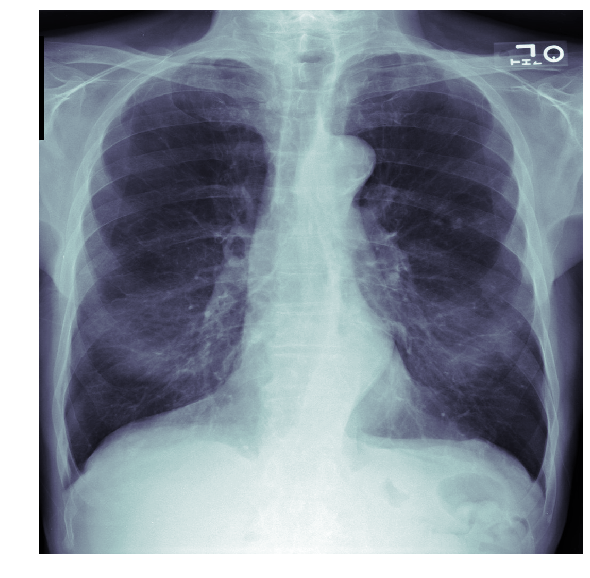

In [22]:
fn = next(TRAIN_PATH.glob('**/*.dcm'))
img = open_image(fn)
show(img)

In [23]:
show_dcm_info(fn)

Filename.........: /work/stages/schwob/siim-pneumothorax/data/train/1.2.276.0.7230010.3.1.4.8323329.14243.1517875250.398380.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: eff52c22-7c7b-4c6f-9173-671c2ad56a1f, 
Patient id..........: eff52c22-7c7b-4c6f-9173-671c2ad56a1f
Patient's Age.......: 79
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 144656 bytes
Pixel spacing....: ['0.171', '0.171']


In [24]:
img.shape

(1024, 1024)

In [25]:
def mask2rle(img, width, height):
    rle = []
    lastColor = 0
    currentPixel = 0
    runStart = -1
    runLength = 0

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel
                    runLength = 1
                else:
                    rle.append(str(runStart))
                    rle.append(str(runLength))
                    runStart = -1
                    runLength = 0
                    currentPixel = 0
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor
            currentPixel += 1

    return " ".join(rle)

In [26]:
def rle2mask(rle, width, height):
    if rle == '-1':
        return np.zeros((width, height))
    mask = np.zeros(width * height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height).T

In [27]:
class PneumoSegmentationList(SegmentationItemList):
    def open(self, fn):
        x = open_image(fn)
        x = pil2tensor(x, np.float32)
        x = torch.cat((x, x, x))
        return Image(x/255)

In [28]:
class ImageSegmentFloat(ImageSegment):
    @property
    def data(self):
        return self.px.float()

In [29]:
class MaskList(SegmentationLabelList):
    def __init__(self, *args, train_path=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.train_path = train_path
        
    def open(self, fn):
        assert self.train_path, "a path for train set must be specified"
        img_path = fn[0]
        rle = fn[1]
        h, w = open_image(self.train_path/img_path).shape
        y = rle2mask(rle, w, h)
        y = pil2tensor(y, np.float32)
        return ImageSegmentFloat(y/255)
    
    def analyze_pred(self, pred, thresh: float = 0.5):
        return (pred > thresh).float()
    
    def reconstruct(self, t):
        return ImageSegmentFloat(t.float())

In [30]:
class PneumoClassifList(ImageList):
    def open(self, fn):
        x = open_image(fn)
        x = pil2tensor(x, np.float32)
        x = torch.cat((x, x, x))
        return Image(x/255)

In [31]:
def get_weights(train_list):
    df = train_list.inner_df
    n_tot = df.shape[0]
    df = df.reindex(index=range(n_tot), method='bfill')
    class_weights = []
    weights = np.zeros(n_tot)    
    for c in train_list.classes:
        w = df.loc[df['Labels']==c].shape[0]/n_tot
        w = (1-w)/(train_list.c-1)
        class_weights.append(w)
        weights[df.loc[df['Labels']==c].index.values] = w
    return weights, class_weights

In [32]:
class WeightList:
    def __init__(self, counter, classes=[]):
        assert isinstance(classes, list), "classes must be lists"
        self._counter = counter
        self._classes = classes
        
    def __len__(self):
        return len(self._classes)
    
    def __getitem__(self, key):
        return self._counter[self._classes[key]]
    
    def __iter__(self):
        return iter([self._counter[c] for c in self._classes])
        
    def append(self, c):
        self._classes.append(c)
        
    def pop(self, key):
        self._classes.pop(key)
        
    def increment(self, c):
        self._counter[c] += 1
        
    def inverse(self):
        self._counter = 1/self._counter
        
    def tolist(self):
        return [self._counter[c] for c in self._classes]

In [33]:
def create_sampler(train_list, class_weights):
    weights = [class_weights[c.data] for _, c in train_list.train]
    sampler = WeightedRandomSampler(weights, len(weights))
    return sampler

In [34]:
def load_data(path, bs=8, train_size=256):
    train_list = (PneumoSegmentationList.
                  from_csv(path.parent, path.name).
                  split_by_rand_pct(valid_pct=0.2).
                  label_from_df(cols=[0, 1], classes=['pneum'], label_cls=MaskList, train_path=path.parent).
                  transform(get_transforms(), size=train_size, tfm_y=True).
                  databunch(bs=bs, num_workers=0).
                  normalize())
    return train_list

In [35]:
def load_data_classif(path, bs=8, train_size=256, weight_sample=True):
    train_list = (PneumoClassifList.
                  from_csv(path.parent, path.name).
                  split_by_rand_pct(valid_pct=0.2).
                  label_from_df().
                  transform(get_transforms(), size=train_size))
    if weight_sample:
        weights, class_weights = get_weights(train_list)
        sampler = WeightedRandomSampler(weights, len(weights))
        
    train_list = train_list.databunch(bs=bs, num_workers=0).normalize()
    
    if weight_sample:
        train_list.train_dl = train_list.train_dl.new(shuffle=False, sampler=sampler)
        return train_list, class_weights
    
    return train_list, None

In [36]:
db = load_data(LABELS_POS, bs=BATCH_SIZE, train_size=TRAIN_SIZE)

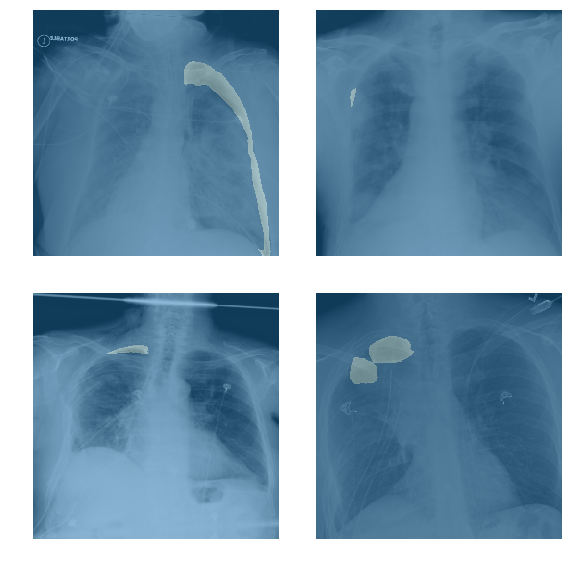

In [37]:
db.show_batch(rows=3, cmap=plt.cm.bone)

In [103]:
def dice(input, target, thr=None, smooth=1., reduction='mean'):
    assert input.shape==target.shape, "input and target must have same shape"
    iflat = torch.sigmoid(input).view(input.size(0), -1)
    if thr: iflat = (iflat>thr).float()
    tflat = target.view(target.size(0), -1)
    
    intersection = (iflat * tflat).sum(-1)
    dice = (2. * intersection + smooth)/(iflat.sum(-1) + tflat.sum(-1) + smooth)
    
    if reduction=='mean':
        return dice.mean()
    elif reduction=='sum':
        return dice.sum()
    else:
        return dice

In [39]:
def dice_loss(input, target, smooth=1e-2, **kwargs):
    return 1-dice(input, target, smooth=smooth, **kwargs)

In [40]:
def bce_dice_loss(input, target, a=0.5, b=0.5, smooth=1., weights=None, **kwargs):
    return a*dice_loss(input, target, smooth=smooth, **kwargs)+b*binary_cross_entropy_with_logits(input, target, pos_weight=weights, **kwargs)

In [41]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1., reduction='mean'):
        super().__init__()
        self.smooth = smooth
        self.reduction = reduction
    
    def forward(self, input, target):
        return dice_loss(input, target, smooth=self.smooth, reduction=self.reduction)

In [42]:
class BCEDiceLoss(nn.Module):
    def __init__(self, a=0.5, b=0.5, smooth=1., weights=None, reduction='mean'):
        super().__init__()
        self.a = a
        self.b = b
        self.smooth = smooth
        self.weights = weights
        self.reduction = reduction
        
    def forward(self, input, target, **kwargs):
        return bce_dice_loss(input, target, a=self.a, b=self.b, smooth=self.smooth, weights=self.weights, reduction=self.reduction)

In [43]:
class RandomSampler(Sampler):
    def __init__(self, model, loss, dl, num_samples, bs):
        assert loss.reduction=='none', 'Loss function must disable reduction'
        self.model = model
        self.bs = bs
        self.dl = dl.new(shuffle=False, sampler=None)
        self.loss = loss
        self.num_samples = num_samples

    def get_scores(self):
        losses = []
        with torch.no_grad():
            for X, y_true in self.dl:
                y_pred = self.model(X)
                loss = self.loss(y_pred, y_true)
                losses.append(loss)
        return torch.cat(losses)

    def __iter__(self):
        scores = self.get_scores()
        return iter(torch.multinomial(scores, self.num_samples, True).tolist())

    def __len__(self):
        return self.num_samples

In [44]:
learner = unet_learner(db, models[MODEL], pretrained=PRETRAINED, loss_func=BCEDiceLoss(a=0.8, b=0.2), wd=WD, model_dir=MODELS_PATH, metrics=[dice])

In [45]:
next(learner.model.children())[0].load_state_dict(torch.load(STATE_DICT_PATH))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [46]:
learner.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (2634 items)
x: PneumoSegmentationList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MaskList
ImageSegmentFloat (1, 256, 256),ImageSegmentFloat (1, 256, 256),ImageSegmentFloat (1, 256, 256),ImageSegmentFloat (1, 256, 256),ImageSegmentFloat (1, 256, 256)
Path: /work/stages/schwob/siim-pneumothorax/data;

Valid: LabelList (658 items)
x: PneumoSegmentationList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MaskList
ImageSegmentFloat (1, 256, 256),ImageSegmentFloat (1, 256, 256),ImageSegmentFloat (1, 256, 256),ImageSegmentFloat (1, 256, 256),ImageSegmentFloat (1, 256, 256)
Path: /work/stages/schwob/siim-pneumothorax/data;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.

In [47]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


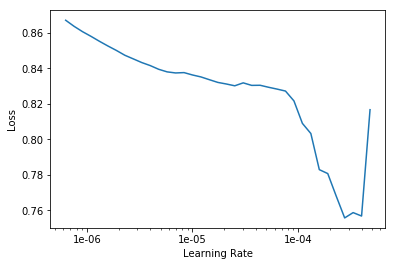

In [48]:
learner.recorder.plot(skip_end=1)

In [50]:
learner.fit_one_cycle(
    10, slice(LR),
    callbacks=[
        SaveModelCallback(
            learner, monitor='dice', name='seg_resnet152_0')])

epoch,train_loss,valid_loss,dice,time
0,0.566392,0.602401,0.283075,11:39
1,0.583681,0.612851,0.283681,11:10
2,0.617626,0.596599,0.282728,10:55
3,0.491793,0.432333,0.478831,10:50
4,0.452754,0.397275,0.522256,11:37
5,0.411106,0.393566,0.525876,11:05
6,0.440833,0.378697,0.541772,11:00
7,0.449606,0.413564,0.499784,10:46
8,0.410267,0.375889,0.544983,10:39
9,0.397370,0.369766,0.551799,10:40


Better model found at epoch 0 with dice value: 0.28307536244392395.
Better model found at epoch 1 with dice value: 0.28368112444877625.
Better model found at epoch 3 with dice value: 0.47883138060569763.
Better model found at epoch 4 with dice value: 0.5222564339637756.
Better model found at epoch 5 with dice value: 0.5258759260177612.
Better model found at epoch 6 with dice value: 0.5417720079421997.
Better model found at epoch 8 with dice value: 0.5449829697608948.
Better model found at epoch 9 with dice value: 0.5517992973327637.


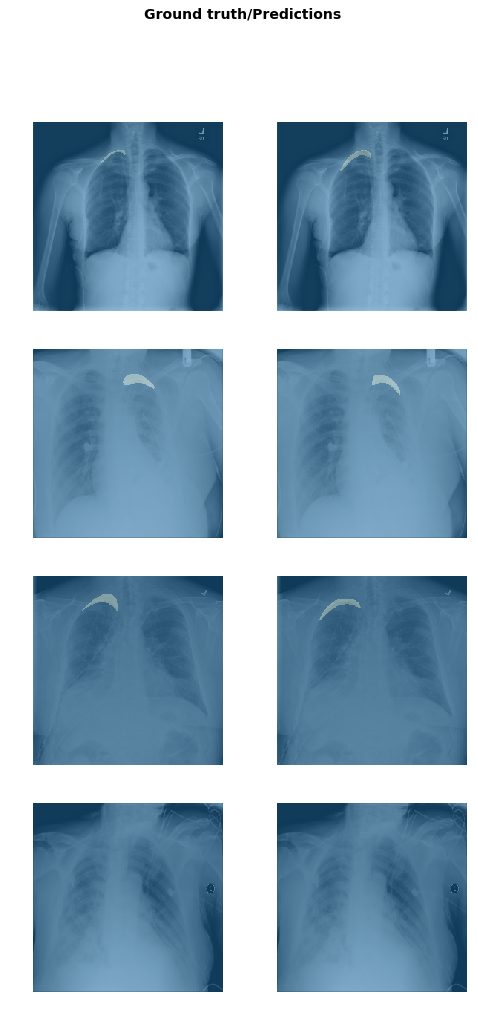

In [51]:
learner.show_results()

In [64]:
learner.unfreeze()

In [62]:
learner.lr_find(num_it=2000)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


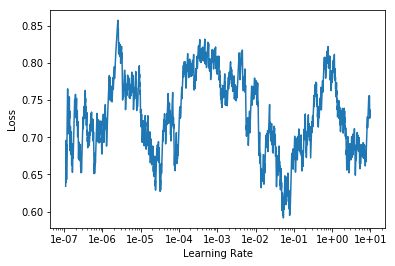

In [63]:
learner.recorder.plot(skip_end=1)

In [ ]:
learner.fit_one_cycle(
    10, slice(1e-2),
    callbacks=[
        SaveModelCallback(
            learner, monitor='dice', name='first_test_unfrozen')])

In [52]:
test_list = (PneumoSegmentationList.
             from_folder(TEST_PATH, extensions=['.dcm']))
db.add_test(test_list, tfms=(), tfm_y=False)

In [54]:
preds = learner.get_preds(DatasetType.Test)

In [56]:
preds = preds[0]

In [57]:
preds = torch.sigmoid(preds)

In [97]:
valid_preds, valid_gt = learner.get_preds(DatasetType.Valid)

In [123]:
def get_best_thr(preds, gt, plot=True):
    thrs = np.arange(0.01, 1, 0.01)
    dices = []
    for i in tqdm(thrs):
        dices.append(dice(preds_m, valid_gt, thr=i).item())
    dices = np.array(dices)
    best_dice = dices.max()
    best_thr = thrs[dices.argmax()]
    
    if plot:
        plt.figure(figsize=(8,4))
        plt.plot(thrs, dices)
        plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
        plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
        plt.show()
    
    return best_thr

In [122]:
def create_submission(preds, path, thr=0.5):
    sub = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])
    index = 0
    for k, pred in tqdm(enumerate(preds.squeeze()), total=preds.size(0)):
        y = pred.numpy()
        y = cv2.resize(y, (1024, 1024), interpolation=cv2.INTER_CUBIC)
        labels = label(y>thr)
        id = db.test_ds.items[k].with_suffix('').name
        if labels.max() == 0:
            sub.loc[index] = [id, '-1']
            index += 1
        for i in range(1, labels.max()+1):
            mask = (labels==i).astype(np.uint8)*255
            rle = mask2rle(mask.T, 1024, 1024)
            sub.loc[index] = [id, rle]
            index += 1
    sub.to_csv(path, index=False)
    return sub

In [287]:
db_clf, class_weights = load_data_classif(LABELS_CLASSIF, bs=BATCH_SIZE, train_size=TRAIN_SIZE, weight_sample=True)

In [289]:
clf = cnn_learner(db_clf, models['resnet152'], pretrained=PRETRAINED,
                  loss_func=nn.CrossEntropyLoss(weight=torch.tensor(class_weights, device=db_clf.device)),
                  wd=WD, model_dir=MODELS_PATH, metrics=[accuracy])

In [225]:
loss =  nn.CrossEntropyLoss(weight=torch.tensor(class_weights, device=db_clf.device), reduction='none')
sampler = RandomSampler(clf.model, loss, db_clf.train_dl, len(db_clf.train_ds), db_clf.batch_size)

In [226]:
clf.data.train_dl = db_clf.train_dl.new(shuffle=False, sampler=sampler)

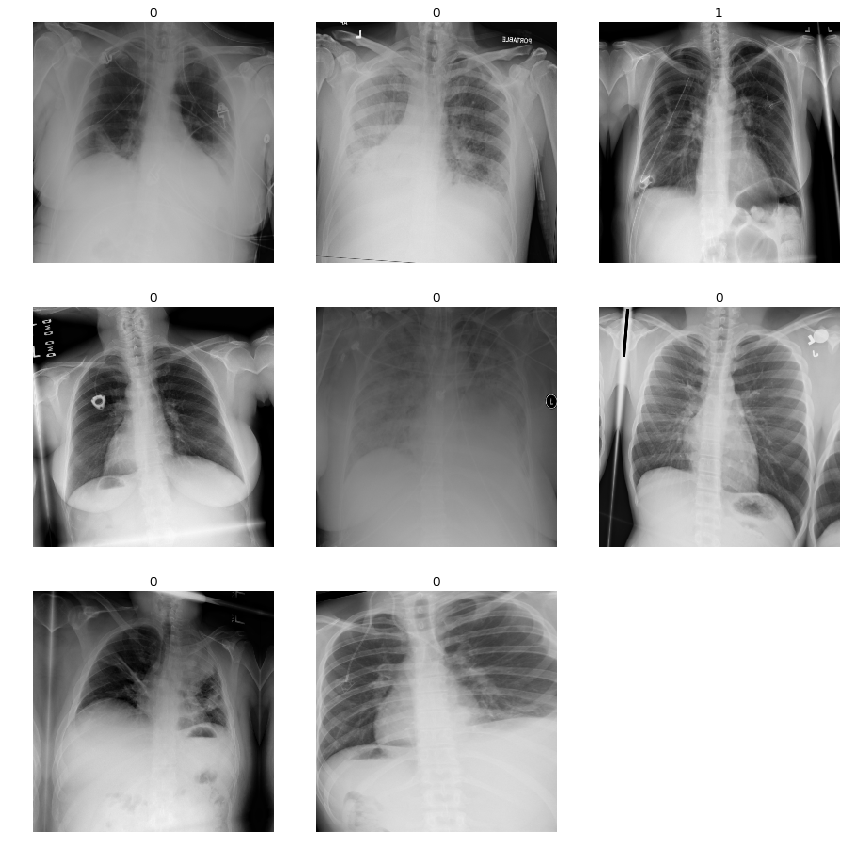

In [227]:
db_clf.show_batch(cmap=plt.cm.bone)

In [290]:
clf.unfreeze()

In [291]:
clf.load('clf_resnet152_0').to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (8540 items)
x: PneumoClassifList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
0,1,1,1,0
Path: /work/stages/schwob/siim-pneumothorax/data;

Valid: LabelList (2135 items)
x: PneumoClassifList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
1,0,1,0,0
Path: /work/stages/schwob/siim-pneumothorax/data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [292]:
clf.lr_find(num_it=500)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


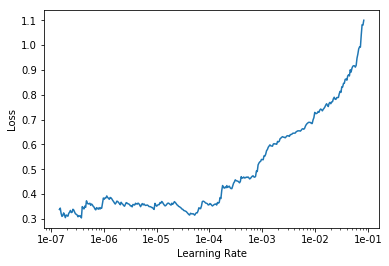

In [293]:
clf.recorder.plot()

In [ ]:
clf.fit_one_cycle(
    50, slice(3e-5),
    callbacks=[
        SaveModelCallback(
            clf, monitor='accuracy', name='clf_resnet152_2')])

epoch,train_loss,valid_loss,accuracy,time
0,0.391473,0.263324,0.912881,08:29
1,0.344152,0.257163,0.897424,07:26
2,0.333721,0.257013,0.892740,07:25


Better model found at epoch 0 with accuracy value: 0.912880539894104.


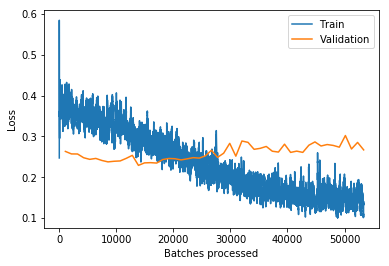

In [295]:
clf.recorder.plot_losses()

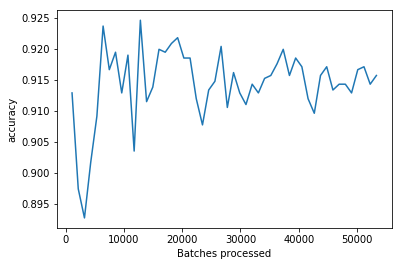

In [296]:
clf.recorder.plot_metrics()

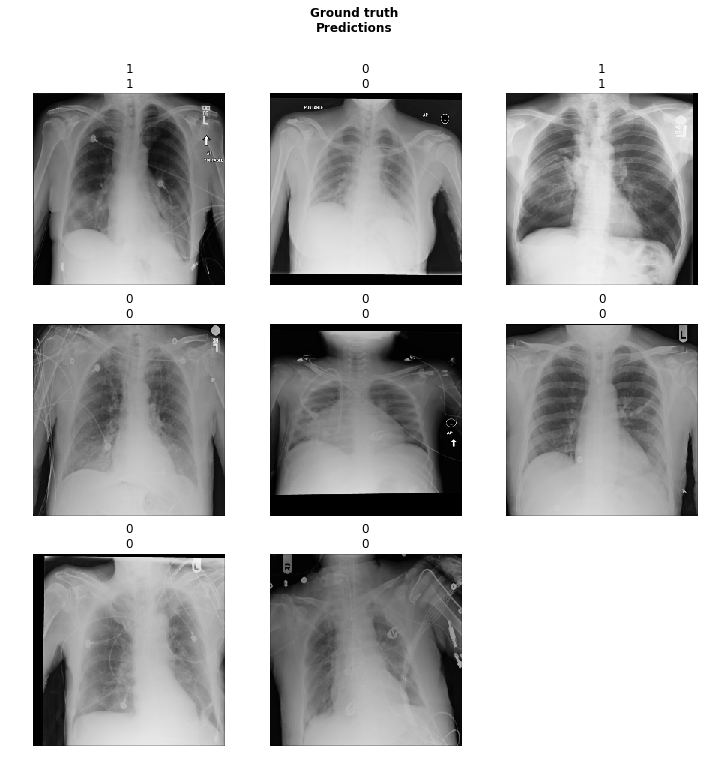

In [297]:
clf.show_results()

In [298]:
interp = clf.interpret()

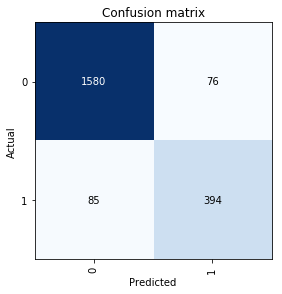

In [299]:
interp.plot_confusion_matrix()

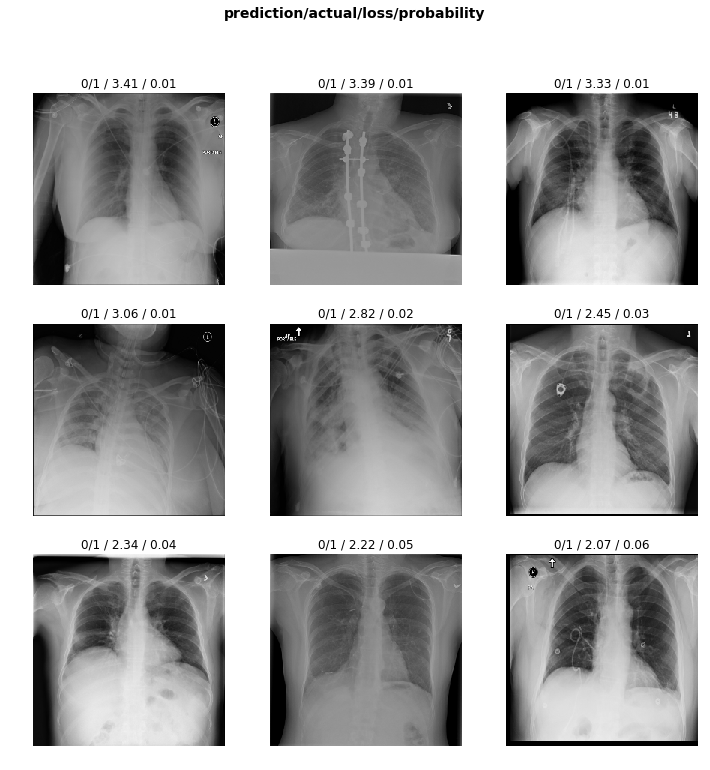

In [302]:
interp.plot_top_losses(9, heatmap=False)

In [307]:
df = pd.read_csv(LABELS_CLASSIF)
stats = pd.DataFrame(columns=['ImageId', 'Age', 'Sex', 'Height', 'Width', 'Pneumo'])
for row in tqdm(df.itertuples(), total=df.shape[0]):
    fn = row.ImageId
    ds = pydicom.dcmread(str(DATA/fn))
    h, w = ds.pixel_array.shape
    stats.loc[row.Index] = [row.ImageId, int(ds.PatientAge), ds.PatientSex, h, w, int(row.Labels)]

In [308]:
stats.head()

,ImageId,Age,Sex,Height,Width,Pneumo
0,train/1.2.276.0.7230010.3.1.4.8323329.5597.151...,51,F,1024,1024,0
1,train/1.2.276.0.7230010.3.1.4.8323329.12515.15...,17,F,1024,1024,0
2,train/1.2.276.0.7230010.3.1.4.8323329.4904.151...,69,F,1024,1024,1
3,train/1.2.276.0.7230010.3.1.4.8323329.32579.15...,57,F,1024,1024,1
4,train/1.2.276.0.7230010.3.1.4.8323329.1314.151...,16,M,1024,1024,1


In [36]:
stats.loc[stats['Sex']=='F'].shape[0]

4795

In [37]:
stats.loc[stats['Sex']=='M'].shape[0]

5880

In [313]:
stats_age = stats.groupby(pd.cut(stats['Age'], list(range(0, 101, 10))+[450]))

In [39]:
stats_age.count()['Pneumo']

Age
(0, 10]        135
(10, 20]       674
(20, 30]      1266
(30, 40]      1498
(40, 50]      2059
(50, 60]      2606
(60, 70]      1769
(70, 80]       600
(80, 90]        65
(90, 100]        1
(100, 450]       2
Name: Pneumo, dtype: int64

In [309]:
stats_age.sum()['Pneumo']/stats_age.count()['Pneumo']

Age
(0, 10]       0.074074
(10, 20]      0.330861
(20, 30]      0.256714
(30, 40]      0.197597
(40, 50]      0.206897
(50, 60]      0.208749
(60, 70]      0.220464
(70, 80]      0.243333
(80, 90]      0.292308
(90, 100]     0.000000
(100, 450]    0.000000
Name: Pneumo, dtype: float64

In [314]:
stats_sex = stats.groupby('Sex')

In [314]:
stats_sex.count()['Pneumo']

Sex
F    4795
M    5880
Name: Pneumo, dtype: int64

In [313]:
stats_sex.sum()['Pneumo']/stats_sex.count()['Pneumo']

Sex
F    0.219604
M    0.225510
Name: Pneumo, dtype: float64

In [303]:
losses, idxs = interp.top_losses()

In [304]:
idxs = idxs.numpy()

In [305]:
ids = []
for i, l in zip(idxs, losses):
    if l.item()<0.2:
        break
    id = Path(interp.ds.items[i])
    id = Path(id.parent.name)/id.name
    ids.append(str(id))

In [309]:
top_losses = stats.loc[stats['ImageId'].isin(ids)]

In [310]:
top_losses.head()

,ImageId,Age,Sex,Height,Width,Pneumo
7,train/1.2.276.0.7230010.3.1.4.8323329.4440.151...,65,F,1024,1024,1
44,train/1.2.276.0.7230010.3.1.4.8323329.13361.15...,52,F,1024,1024,1
52,train/1.2.276.0.7230010.3.1.4.8323329.14508.15...,21,M,1024,1024,1
70,train/1.2.276.0.7230010.3.1.4.8323329.4333.151...,58,M,1024,1024,1
79,train/1.2.276.0.7230010.3.1.4.8323329.3140.151...,62,F,1024,1024,1


In [311]:
top_losses.groupby('Pneumo').count().head()['ImageId']

Pneumo
0     73
1    191
Name: ImageId, dtype: int64

In [315]:
top_losses.groupby('Sex').count().head()['ImageId']/stats_sex.count()['Pneumo']

Sex
F    0.022941
M    0.026190
dtype: float64

In [316]:
top_losses.groupby(pd.cut(top_losses['Age'], list(range(0, 101, 10))+[450])).count().head()['ImageId']/stats_age.count()['Pneumo']

Age
(0, 10]       0.022222
(10, 20]      0.025223
(20, 30]      0.033175
(30, 40]      0.022029
(40, 50]      0.019427
(50, 60]           NaN
(60, 70]           NaN
(70, 80]           NaN
(80, 90]           NaN
(90, 100]          NaN
(100, 450]         NaN
dtype: float64

In [341]:
torch.save(next(clf.model.children()).state_dict(), MODELS_PATH/'resnet152_backbone_pretrained.pth')

In [350]:
clf.destroy()

this Learner object self-destroyed - it still exists, but no longer usable
